In [1]:
import cv2
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
import os
from deepface import DeepFace as df
#from retinaface import RetinaFace as m
#from PIL import Image
#import imagehash
import pandas as pd
from pymongo import MongoClient


import mediapipe as mp

576 576


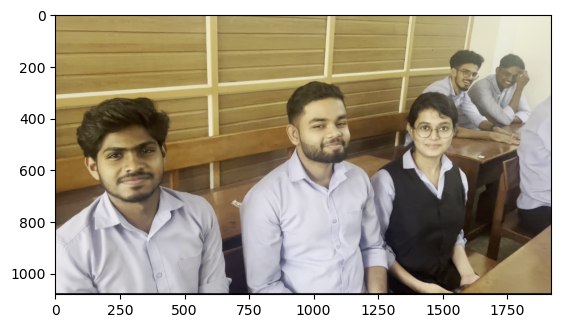

In [2]:
video = cv2.VideoCapture('Data/Video/input2.MOV')
count = 0
frames_arr = []
while video.isOpened():
    ret, frame = video.read()

    if not ret:
        break
    frames_arr.append(frame)                                         # Frames stored in frames_arr
    count += 1
video.release()
print(len(frames_arr), count)


img = frames_arr[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [3]:
%%time
frames = []
frames.append(frames_arr[0])
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for i in range(1, len(frames_arr)):
    keypoints1, descriptors1 = orb.detectAndCompute(frames[-1], None)
    keypoints2, descriptors2 = orb.detectAndCompute(frames_arr[i], None)
    matches = bf.match(descriptors1, descriptors2)
    
    #matches = sorted(matches, key=lambda x: x.distance)
    
    if len(matches) < 200:
        frames.append(frames_arr[i])
print(len(frames))


55
CPU times: total: 37 s
Wall time: 42.7 s


In [4]:
%%time
detected_faces = []
img = frames_arr[0]
mp_face_detction = mp.solutions.face_detection
for frame in frames:
    with mp_face_detction.FaceDetection(model_selection = 1, min_detection_confidence = 0.5) as face_detection:
        results = face_detection.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        for detection in results.detections:
            box = detection.location_data.relative_bounding_box
            x_start, y_start = int(box.xmin * img.shape[1]), int(box.ymin * img.shape[0])
            x_end, y_end = int((box.xmin + box.width) * img.shape[1]), int((box.ymin + box.height) * img.shape[0])

            if x_start < 0 or y_start < 0:
                continue

            face = frame[y_start:y_end, x_start:x_end]
            face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
            detected_faces.append(face)
print(len(detected_faces))

266
CPU times: total: 3.11 s
Wall time: 4.26 s


258


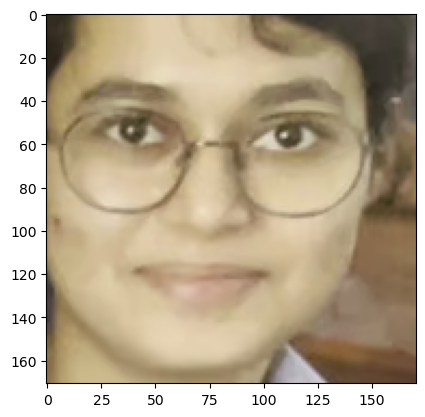

In [5]:
faces = []
faces.append(cv2.convertScaleAbs(detected_faces[0]))
orb = cv2.ORB_create()
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for i in range(1, len(detected_faces)):
    img2 = cv2.convertScaleAbs(detected_faces[i])

    

    keypoints1, descriptors1 = orb.detectAndCompute(faces[-1], None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2, None)

    if descriptors2 is None:
        
        continue

    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    matches = bf.match(descriptors1, descriptors2)

    #matches = sorted(matches, key=lambda x: x.distance)

    if len(matches) < 200:
        faces.append(detected_faces[i])

detected_faces[:]=faces[:]
print(len(detected_faces))

plt.imshow(detected_faces[2])

In [6]:
#connect to database
client=MongoClient('mongodb://localhost:27017')
try:
    client.admin.command('ping')
    print("Pinged your deployment. You successfully connected to MongoDB!")
except Exception as e:
    print(e)    
    

Pinged your deployment. You successfully connected to MongoDB!


In [7]:
db=client['students']

In [8]:
classes_collection=db['classes']
known_faces_collection=db['known_faces']
attendance_collection=db['attendance']
student_collection=db['stud_details']


In [11]:
#store pkl file to db
import pickle
from bson.binary import Binary



# Load data from a Pickle file
with open('Data/known_faces/representations_facenet.pkl', 'rb') as file:
    data_to_store = pickle.load(file)

# Convert the loaded data to binary using pickle
binary_data = Binary(pickle.dumps(data_to_store))

# Insert the binary data into MongoDB
classes_collection.insert_one({'class':'2k20','pkl': binary_data})





InsertOneResult(ObjectId('65e2ed565d90007ea97956ba'), acknowledged=True)

In [12]:
%%time
#recognize faces and find present students

import tempfile
import pickle
from bson.binary import Binary
import shutil



# Specify the condition for fetching documents
condition = {"class": "2k20"}

# Retrieve the document from MongoDB based on the condition
document = classes_collection.find_one(condition)

if document:
    # Retrieve the binary data from the MongoDB document
    binary_data_from_mongo = document['pkl']

    # Create a temporary folder
    temp_folder = tempfile.mkdtemp()

    # Path to the Pickle file inside the temporary folder
    pickle_file_path = f"{temp_folder}/representations_facenet.pkl"

    # Save the binary data to the temporary folder
    with open(pickle_file_path, 'wb') as file:
        file.write(binary_data_from_mongo)
        

    # Load the Pickle file from mongodb
    with open(pickle_file_path, 'rb') as file:
        loaded_data = pickle.load(file)
    # Perform some processing with the loaded data-face recognition
    models=[]
    res=[]
    present=[]
    for i in range(len(detected_faces)):
        model=df.find(img_path=detected_faces[i],db_path=temp_folder,model_name="Facenet",distance_metric="euclidean",enforce_detection=False,normalization="Facenet",detector_backend='mediapipe')
        models.append(model)
    print()
    count = 0
    for model in models:
        if len(model)>0 and len(model[0]) > 0:
            name=model[0]['identity'].values[0].split('\\')[-1].split('/')[-1].split('.')[-2]
            print(count , "_ ", name)
            if name not in present:
                present.append(name)
        else:
            print('Unknown Face detected')
        count += 1
    print(present)
    # Clean up: Delete the temporary folder and its contents
    shutil.rmtree(temp_folder)
else:
    print("No document found with class attribute '2k20' in MongoDB.")


There are  54  representations found in  representations_facenet.pkl
find function lasts  0.38090062141418457  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.18799805641174316  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.19507384300231934  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.18812251091003418  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1530895233154297  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1465301513671875  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1541426181793213  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.144667387008667  seconds
There are  54  representations found in  representati

find function lasts  0.15597271919250488  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1491410732269287  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14334797859191895  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14110183715820312  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14060568809509277  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13770103454589844  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14154839515686035  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1337904930114746  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14466476440429688  seconds


find function lasts  0.14461326599121094  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14252734184265137  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15546274185180664  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14245009422302246  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13875436782836914  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14594483375549316  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14599871635437012  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14500093460083008  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1456925868988037  seconds

find function lasts  0.14195656776428223  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13852143287658691  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13832807540893555  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13399910926818848  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1481003761291504  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14824938774108887  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13977813720703125  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13604736328125  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.140883207321167  seconds
Ther

find function lasts  0.13958334922790527  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14103221893310547  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15196871757507324  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13493943214416504  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14445757865905762  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14220356941223145  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1457347869873047  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14422392845153809  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14750051498413086  seconds

find function lasts  0.1479661464691162  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14953279495239258  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15449905395507812  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13898515701293945  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14224672317504883  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14129328727722168  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1605544090270996  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14337992668151855  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.149993896484375  seconds
Th

find function lasts  0.14389348030090332  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.136430025100708  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1371750831604004  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1415083408355713  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1487724781036377  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15216588973999023  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14296531677246094  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14822840690612793  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14563560485839844  seconds
The

find function lasts  0.14996981620788574  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13853788375854492  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14260029792785645  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13916778564453125  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13703155517578125  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1308884620666504  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14033770561218262  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.135545015335083  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14083147048950195  seconds
T

find function lasts  0.160966157913208  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14510774612426758  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14719295501708984  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13639616966247559  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1454169750213623  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14152884483337402  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14005661010742188  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13804388046264648  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14640140533447266  seconds
T

find function lasts  0.14256858825683594  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13905549049377441  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14146137237548828  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13599920272827148  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14473557472229004  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.13999533653259277  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14600157737731934  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14704179763793945  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15587782859802246  second

find function lasts  0.15674996376037598  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1420154571533203  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1465590000152588  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.14888405799865723  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.15352535247802734  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.20520949363708496  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.2511017322540283  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.16494131088256836  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1381239891052246  seconds
Th

find function lasts  0.18295621871948242  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.17731857299804688  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.19151973724365234  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.17966675758361816  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.18440032005310059  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1687307357788086  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.1793670654296875  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.19896507263183594  seconds
There are  54  representations found in  representations_facenet.pkl
find function lasts  0.18562841415405273  seconds


CPU times: total: 27.3 s
Wall time: 41 s


In [ ]:
# Function to get absent students
def get_absent_students(present, collection):
    
    
    # Query MongoDB for students not present
    absent_students = collection.find({'name': {'$nin': present}})
    
    # Extract student names from MongoDB cursor
    absent = [student['name'] for student in absent_students]
    
    return absent

# Example usage
if __name__ == "__main__":
    
    collection_name = student_collection # Name of the MongoDB collection
    
    
    absent = get_absent_students(present, collection_name)
    print("Absent Students:", absent)

In [ ]:
#generate csv file#store data in attendance collection
import csv
from datetime import datetime
# Function to generate CSV file from MongoDB
def generate_csv_from_document(document, output_file):
    # Prepare data for CSV file
    csv_data = [['Class', 'Period', 'Date', 'Time', 'Present Students', 'Absent Students'],
                [document['class'], document['period'], document['date'], document['time'], ','.join(document.get('present', [])), ','.join(document.get('absent', []))]]
    
    # Write data to CSV file
    with open(output_file, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    print("CSV file generated successfully.")



# Get input from user
batch = input('Enter class: ')
period = input('Enter period: ')
date = datetime.now().strftime('%Y-%m-%d')
time = datetime.now().strftime('%H:%M:%S')
present = present  # You need to define the 'present' list here
absent = absent   # You need to define the 'absent' list here

# Insert document into MongoDB collection
inserted_document = {"class": batch, "period": period, "date": date, "time": time, "present": present, "absent": absent}
attendance_collection.insert_one(inserted_document)
# Generate CSV file immediately after inserting the document
generate_csv_from_document(inserted_document, 'Data/attendance.csv')

In [ ]:

# Function to import data from CSV to MongoDB
def import_csv_to_mongodb(csv_file, collection):
    # Read CSV file into a pandas DataFrame
    data = pd.read_csv(csv_file)
    

    
    
    # Convert DataFrame to dictionary
    data_dict = data.to_dict(orient='records')
    
    # Insert data into MongoDB collection
    collection.insert_many(data_dict)
    
   
    
    print("Data imported successfully into MongoDB.")

# Example usage
if __name__ == "__main__":
    csv_file = 'Data/names.csv'  # Path to your CSV file
    collection_name = student_collection  # Name of the MongoDB collection
    
    
    import_csv_to_mongodb(csv_file, collection_name)

In [ ]:
# %%time
# detected=[]
# detected_faces=[]
# for frame in frames[:10]:
#     detected.append(df.extract_faces(frame))
# for i in range(len(detected)):
#     detected_faces.append(detected[i][1]['face'])



CPU times: total: 0 ns
Wall time: 26 ms


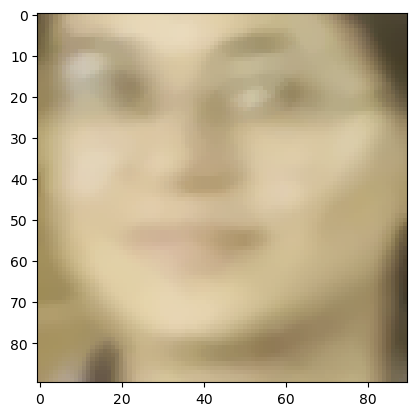

In [67]:
%%time
#image denoising using opencv

import numpy as np

def deblur_image(image):
    # Perform deblurring using your preferred method
    # This could be a function like the one provided earlier
    # For simplicity, I'll assume a placeholder deblurring function here
    deblurred_image = cv2.medianBlur(image, 5)  # Placeholder deblurring function
    return deblurred_image
 
deblurred_face = deblur_image(detected_faces[100])
plt.imshow(deblurred_face)

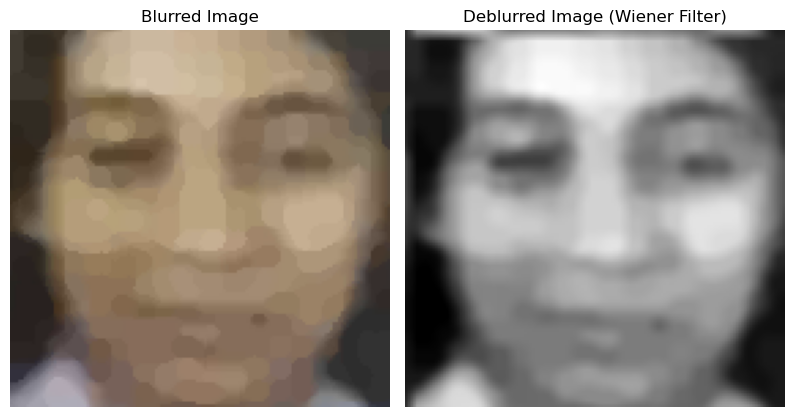

In [54]:
#wiener
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage import color, data
from scipy.ndimage import gaussian_filter
from skimage import img_as_float

def wiener_filter_deblur(blurred_image, psf, regularization):
    # Convert the image to grayscale if it's in color
    if blurred_image.ndim == 3:
        blurred_image = color.rgb2gray(blurred_image)

    # Convert the PSF and the blurred image to float
    psf = psf.astype(float)
    blurred_image = blurred_image.astype(float)

    # Resize the PSF to match the size of the blurred image
    psf_resized = np.zeros_like(blurred_image)
    psf_resized[:psf.shape[0], :psf.shape[1]] = psf

    # Apply the Wiener filter to deblur the image
    wiener_filter = np.conj(psf_resized) / (np.abs(psf_resized) ** 2 + regularization)
    deblurred_image = np.real(np.fft.ifft2(np.fft.fft2(blurred_image) * np.fft.fft2(wiener_filter)))

    return deblurred_image

# Load your own blurred image
#blurred_image = plt.imread('Data/WIN_20240217_22_04_07_Pro.jpg')
blurred_image = deblurred_face

# Define the PSF (Point Spread Function)
psf = np.ones((5, 5)) / 25  # Example PSF, you should replace it with your actual PSF

# Set the regularization parameter for the Wiener filter
regularization_param = 0.1  # Adjust this parameter based on your image characteristics

# Deblur the image using the Wiener filter
deblurred_image = wiener_filter_deblur(blurred_image, psf, regularization_param)

# Normalize the deblurred image to range [0, 1]
deblurred_image_normalized = (deblurred_image - np.min(deblurred_image)) / (np.max(deblurred_image) - np.min(deblurred_image))

deblurred_image_uint8 = (deblurred_image_normalized * 255).astype(np.uint8)
# Convert the deblurred image to RGB
deblurred_image_rgb = color.gray2rgb(deblurred_image_uint8)

# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(blurred_image, cmap='gray')
plt.title('Blurred Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(deblurred_image_rgb)
plt.title('Deblurred Image (Wiener Filter)')
plt.axis('off')

plt.tight_layout()
plt.show()


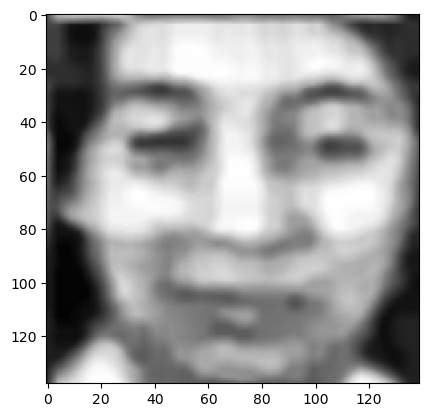

In [55]:
#contrast enhancement
import cv2
import numpy as np

img = deblurred_image_rgb
# converting to LAB color space
lab= cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
l_channel, a, b = cv2.split(lab)

# Applying CLAHE to L-channel
# feel free to try different values for the limit and grid size:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(l_channel)

# merge the CLAHE enhanced L-channel with the a and b channel
limg = cv2.merge((cl,a,b))

# Converting image from LAB Color model to BGR color spcae
enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
plt.imshow(enhanced_img)

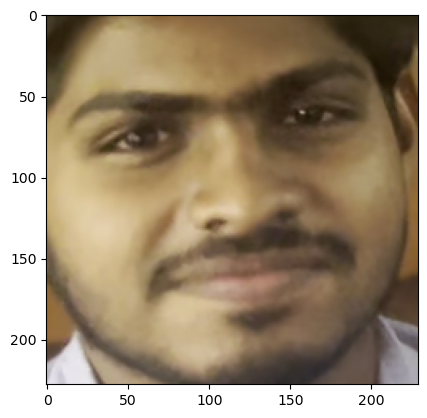

In [20]:
plt.imshow(detected_faces[3])

In [9]:
model=df.find(img_path=detected_faces[3],db_path='Data/known_faces',model_name="Facenet",distance_metric="euclidean",enforce_detection=False,normalization="Facenet",detector_backend='mediapipe')


Finding representations: 100%|█████████████████████████████████████████████████████████| 54/54 [00:30<00:00,  1.79it/s]


Representations stored in Data/known_faces/representations_facenet.pkl file.Please delete this file when you add new identities in your database.
find function lasts  30.543634176254272  seconds


In [10]:
model[0]

,identity,source_x,source_y,source_w,source_h,Facenet_euclidean
0,Data/known_faces\Amal_G/Amal_G.jpg,0,0,229,228,7.195659
1,Data/known_faces\Aswanth/Aswanth_K1.jpg,0,0,229,228,9.327777
2,Data/known_faces\Aswanth/Aswanth_K.jpg,0,0,229,228,9.610380


In [42]:
%%time
models=[]
res=[]
present=[]
for i in range(len(detected_faces)):
    model=df.find(img_path=detected_faces[i],db_path='Data/known_faces',model_name="Facenet",distance_metric="euclidean",enforce_detection=False,normalization="Facenet",detector_backend='mediapipe')
    models.append(model)
print()
count = 0
for model in models:
    
    if len(model)>0 and len(model[0])>0:
        name=model[0]['identity'].values[0].split('\\')[-1].split('/')[-1].split('.')[-2]
        print(count , "_ ", name)
        if name not in present:
            present.append(name)
    else:
        print('Unknown Face detected')
    count += 1

24-03-02 14:18:10 - find function duration 1.3858892917633057 seconds
24-03-02 14:18:10 - find function duration 0.6016170978546143 seconds
24-03-02 14:18:11 - find function duration 0.8222784996032715 seconds
24-03-02 14:18:12 - find function duration 0.7988555431365967 seconds
24-03-02 14:18:13 - find function duration 0.7485382556915283 seconds
24-03-02 14:18:13 - find function duration 0.7401833534240723 seconds
24-03-02 14:18:14 - find function duration 0.792651891708374 seconds
24-03-02 14:18:15 - find function duration 0.813248872756958 seconds
24-03-02 14:18:16 - find function duration 0.8094069957733154 seconds
24-03-02 14:18:16 - find function duration 0.4457519054412842 seconds
24-03-02 14:18:17 - find function duration 0.7067785263061523 seconds
24-03-02 14:18:17 - find function duration 0.46451234817504883 seconds
24-03-02 14:18:18 - find function duration 0.4521050453186035 seconds
24-03-02 14:18:19 - find function duration 0.7502036094665527 seconds
24-03-02 14:18:19 - f

24-03-02 14:19:23 - find function duration 0.40248608589172363 seconds
24-03-02 14:19:24 - find function duration 0.5861184597015381 seconds
24-03-02 14:19:24 - find function duration 0.38564109802246094 seconds
24-03-02 14:19:25 - find function duration 0.702324628829956 seconds
24-03-02 14:19:26 - find function duration 0.8023090362548828 seconds
24-03-02 14:19:26 - find function duration 0.4439048767089844 seconds
24-03-02 14:19:27 - find function duration 0.760932207107544 seconds
24-03-02 14:19:28 - find function duration 0.7340121269226074 seconds
24-03-02 14:19:29 - find function duration 0.7484784126281738 seconds
24-03-02 14:19:29 - find function duration 0.46984100341796875 seconds
24-03-02 14:19:30 - find function duration 0.5268533229827881 seconds
24-03-02 14:19:30 - find function duration 0.4225647449493408 seconds
24-03-02 14:19:30 - find function duration 0.390561580657959 seconds
24-03-02 14:19:31 - find function duration 0.5090935230255127 seconds
24-03-02 14:19:32 - 

24-03-02 14:20:37 - find function duration 0.4026627540588379 seconds
24-03-02 14:20:37 - find function duration 0.5334882736206055 seconds
24-03-02 14:20:38 - find function duration 0.8896958827972412 seconds
24-03-02 14:20:39 - find function duration 0.6835651397705078 seconds
24-03-02 14:20:39 - find function duration 0.4731473922729492 seconds
24-03-02 14:20:40 - find function duration 0.5192358493804932 seconds
24-03-02 14:20:40 - find function duration 0.48839783668518066 seconds
24-03-02 14:20:41 - find function duration 0.42916274070739746 seconds
24-03-02 14:20:41 - find function duration 0.4519510269165039 seconds
24-03-02 14:20:42 - find function duration 0.38313817977905273 seconds
24-03-02 14:20:42 - find function duration 0.3880753517150879 seconds
24-03-02 14:20:43 - find function duration 0.4671602249145508 seconds
24-03-02 14:20:43 - find function duration 0.4877307415008545 seconds
24-03-02 14:20:43 - find function duration 0.4287121295928955 seconds
24-03-02 14:20:44

In [33]:
print(present)

[]


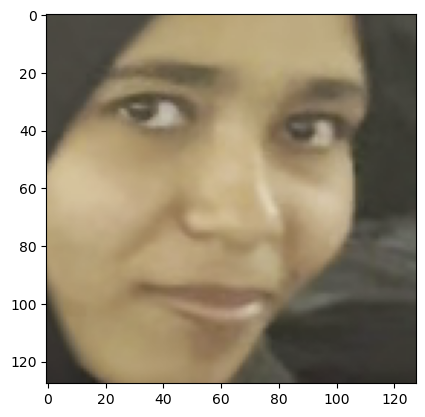

In [41]:
plt.imshow(detected_faces[214])

In [43]:
pip install deepface==0.0.79


  Obtaining dependency information for deepface==0.0.79 from https://files.pythonhosted.org/packages/48/ae/b3e7704245ffa505e0733aadcb5794220e4a5b72941c51ee44548483c1cb/deepface-0.0.79-py3-none-any.whl.metadata
Using cached deepface-0.0.79-py3-none-any.whl (49 kB)
  Attempting uninstall: deepface
    Found existing installation: deepface 0.0.85
    Uninstalling deepface-0.0.85:
      Successfully uninstalled deepface-0.0.85


In [15]:
pip show deepface

Name: deepface
Version: 0.0.85
Summary: A Lightweight Face Recognition and Facial Attribute Analysis Framework (Age, Gender, Emotion, Race) for Python
Home-page: https://github.com/serengil/deepface
Author: Sefik Ilkin Serengil
Author-email: serengil@gmail.com
License: UNKNOWN
Location: C:\Users\wigar\anaconda3\Lib\site-packages
Requires: fire, Flask, gdown, gunicorn, keras, mtcnn, numpy, opencv-python, pandas, Pillow, retina-face, tensorflow, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.
